In [ ]:
from collections import deque

def get_peaksDict(w, positions):
    '''
    A helper function that computes the levels of given positions in a Dyck word w.
    w: Dyckword. The input Dyck word.
    positions: set. The positions to compute levels for.
    Returns: list. The levels of the given positions.
    '''
    level = 0
    peaksDict = {}
    for i in range(len(w)):
        if w[i] == 1:
            level += 1
        else:
            level -= 1
        if i < len(w) and w[i] == 1 and w[i+1] == 0:
            peaksDict.setdefault(level, deque([])).appendleft(i)
    return peaksDict

def scaffolding(w):
    '''
    Returns the output of Zeta map via a "scaffolding" algorithm that only reads information from the right
    once levels are computed. We are obeying the south-west level convention.

    w: list. The input Dyck word.
    '''
    n = len(w)  # semi-length of w

    # 1. Extract the right steps's positions:
    Rs_pos = set(i for i in range(n) if w[i] == 0)

    # 2. Construct the levels for the rights:
    peaksDict = get_peaksDict(w,Rs_pos)   # levels is a helper function that returns the levels of given positions

    # 3. The scaffolding algorithm:
    out = []    # to return result
    queue = []  # a mostly sorted queue that stores tuples (level, position)
                # to be visited, where insertions might also be performed.
    cur_level = max(peaksDict)  # to keep track of which level we are iterating
    alive_agents = deque([])   # to keep track of where we are on the scaffolding. Format: [pos, if_right]

    while len(out) < n:

        peaks = peaksDict.get(cur_level, [])
        if peaks:    # if there are peaks of this level
            queue += peaks    # append the ups before them to queue

        if alive_agents:
            queue += alive_agents  # adding valid agents to queue

        queue.sort(reverse=True)        # sort the same level step by their positions
                                        # this should be fast as it is merging two sorted lists

        out += [w[pos] for pos in queue]    # append this to output
        queue = []              # clear queue

        # now let our agents on the scaffoldings observe and move
        # move existing ones first
        if alive_agents:
            for i in range(len(alive_agents)):  # iterate backwards to allow popping
                agent_pos = alive_agents.popleft()
                if agent_pos in Rs_pos:  # agent is moving right
                    agent_pos = agent_pos + 1
                    if agent_pos in Rs_pos and agent_pos < 2*n: # so it's valid
                        alive_agents.append(agent_pos)  # move agent
                else:   # moving left
                    agent_pos = agent_pos - 1
                    if agent_pos not in Rs_pos and agent_pos >= 0:
                        alive_agents.append(agent_pos)

        # then we add two agents to the right and left of peak
        for peaks_pos in peaks:
            agent_pos = peaks_pos + 1
            if agent_pos in Rs_pos and agent_pos < 2*n:
                alive_agents.append(agent_pos)
            agent_pos = peaks_pos - 1
            if agent_pos not in Rs_pos and agent_pos >= 0:
                alive_agents.append(agent_pos)
        # update current level
        cur_level -= 1
    
    return out

In [ ]:
from collections import deque, defaultdict
from typing import List, Dict, Sequence

def _peaks_by_level_desc(w: List[int]) -> Dict[int, List[int]]:
    n2 = len(w)
    level = 0
    peaks = defaultdict(list)
    for i in range(n2 - 1):  # guard i+1
        level += 1 if w[i] == 1 else -1
        if w[i] == 1 and w[i + 1] == 0:
            peaks[level].append(i)
    for L in peaks:
        peaks[L].reverse()  # make positions descending
    return peaks

def _merge_desc(into: List[int], a: Sequence[int], b: Sequence[int]) -> List[int]:
    """
    Merge two descending sequences a and b into 'into' (descending), without slicing.
    Works for list or deque.
    """
    i = j = 0
    la, lb = len(a), len(b)
    # step through both
    while i < la and j < lb:
        va, vb = a[i], b[j]
        if va >= vb:
            into.append(va); i += 1
        else:
            into.append(vb); j += 1
    # drain remainder (no slicing!)
    while i < la:
        into.append(a[i]); i += 1
    while j < lb:
        into.append(b[j]); j += 1
    return into

def get_peaksDict(w: List[int], positions=None):
    peaks = _peaks_by_level_desc(w)
    return {L: deque(vs) for L, vs in peaks.items()}

def scaffolding_v1(w: List[int]) -> List[int]:
    n2 = len(w)
    Rs = [step == 0 for step in w]  # bool array for O(1) membership

    peaksDict = _peaks_by_level_desc(w)  # lists (descending)
    cur_level = max(peaksDict) if peaksDict else 0

    out: List[int] = []
    alive_agents: deque[int] = deque()     # keep descending order
    queue: List[int] = []

    while len(out) < n2:
        peaks = peaksDict.get(cur_level, [])

        queue.clear()
        if peaks and alive_agents:
            _merge_desc(queue, peaks, alive_agents)
        elif peaks:
            # already descending
            queue.extend(peaks)
        elif alive_agents:
            # already descending
            queue.extend(alive_agents)

        # write output for this round
        out.extend(w[pos] for pos in queue)

        # move existing agents
        if alive_agents:
            moved = deque()
            for _ in range(len(alive_agents)):
                pos = alive_agents.popleft()
                if Rs[pos]:                # moving right
                    np = pos + 1
                    if np < n2 and Rs[np]:
                        moved.append(np)
                else:                      # moving left
                    np = pos - 1
                    if np >= 0 and not Rs[np]:
                        moved.append(np)
            alive_agents = moved

        # spawn around peaks
        if peaks:
            for p in peaks:
                pr = p + 1
                if pr < n2 and Rs[pr]:
                    alive_agents.append(pr)
                pl = p - 1
                if pl >= 0 and not Rs[pl]:
                    alive_agents.append(pl)
            # one sort per level step (could be optimized further if needed)
            alive_agents = deque(sorted(alive_agents, reverse=True))

        cur_level -= 1

    return out

In [25]:
from sage.all import DyckWord, DyckWords

In [108]:
vecs = DyckWords(8)
for v in vecs:
    w = list(v)
    out1 = scaffolding(w)
    out2 = list(v.area_dinv_to_bounce_area_map())
    if out1 != out2:
        print("Mismatch found!")
        print("Input:", w)
        break

In [81]:
# time test
import time

n = 11
vecs = DyckWords(n)

# # randomly sample 1000 words
# import random
# vecs = random.sample(list(vecs), 1000)
# vecs = [DyckWord(list(v)) for v in vecs]

vecs_w = [list(v) for v in vecs]

start = time.time()
for v in vecs_w:
    out1 = scaffolding(v)
end = time.time()
print("Scaffolding time:", end - start)

start = time.time()
for v in vecs:
    out2 = v.area_dinv_to_bounce_area_map()
end = time.time()
print("Built-in time:", end - start)

start = time.time()
for v in vecs_w:
    out3 = scaffolding_v1(v)
end = time.time()
print("Scaffolding_v1 time:", end - start)


Scaffolding time: 2.148768901824951
Built-in time: 2.713838577270508
Scaffolding_v1 time: 1.9313626289367676


In [77]:
# get the area sequence of a Dyck word
def area_sequence(w):
    n = len(w)
    area_seq = []
    level = 0
    for i in range(n):
        if w[i] == 1:
            area_seq.append(level)
            level += 1
        else:
            level -= 1
    return area_seq

In [83]:
start = time.time()

for v in vecs:
    out1 = area_sequence(v)
end = time.time()
print("Area sequence time:", end - start)

start = time.time()
for v in vecs:
    out2 = v.to_area_sequence()
end = time.time()
print("Built-in time:", end - start)

Area sequence time: 1.8688297271728516
Built-in time: 1.4206693172454834


In [98]:
# sweep map
def dyck_ranks(w: Sequence[int]) -> List[int]:
    """
    Rank of each step = y - x at the step's start (SW endpoint).
    Assumes w is a Dyck path of length 2n from (0,0) to (n,n) staying above y=x.
    """
    ranks = []
    rank = 0
    for step in w:
        if step == 1:  # N
            rank += 1
        else:          # E
            rank -= 1
        ranks.append(rank)
    return ranks

def sweep_map(w: Sequence[int]) -> List[int]:
    """
    Sweep map on Dyck paths (Loehr–Warrington / Haglund style):
    - Compute rank r_i = y_i - x_i at the start of step i.
    - Sort steps by increasing rank; break ties by scanning **right-to-left** (i.e., larger i first).
    - Output the step multiset in that order.

    Returns a Dyck word of the same length.
    """
    n2 = len(w)
    r = dyck_ranks(w)

    # Indices 0..2n-1, tie-broken right-to-left within each rank: use (-i)
    order = sorted(range(n2), key=lambda i: (r[i], i), reverse=True)

    # Emit steps in that order (this is guaranteed to be Dyck)
    out = [w[i] for i in order]
    return out

In [99]:
vecs = DyckWords(10)
for v in vecs:
    w = list(v)
    out1 = sweep_map(w)
    out2 = list(v.area_dinv_to_bounce_area_map())
    if out1 != out2:
        print("Mismatch found!")
        print("Input:", w)
        print("Output sweep_map:", out1)
        print("Output built-in:", out2)
        break

In [109]:
vecs = DyckWords(11)
vecs_w = [list(v) for v in vecs]

start = time.time()
for v in vecs_w:
    out1 = scaffolding_v1(v)
end = time.time()
print("Scaffolding time:", end - start)

start = time.time()
for v in vecs:
    out2 = v.area_dinv_to_bounce_area_map()
end = time.time()
print("Built-in time:", end - start)

start = time.time()
for v in vecs:
    out2 = sweep_map(list(v))
end = time.time()
print("Sweep map time:", end - start)

Scaffolding time: 1.924407720565796
Built-in time: 2.6868908405303955
Sweep map time: 2.160309076309204


Saved: dyck_scaffolding.gif


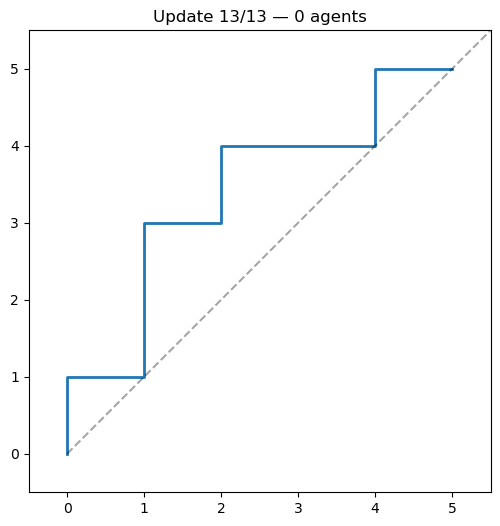

In [14]:
from matplotlib import animation
import matplotlib.pyplot as plt
from imojify import imojify
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from collections import deque
import numpy as np


# ===============================
# Helper: compute peaks
# ===============================
def get_peaksDict(w, positions):
    level = 0
    peaksDict = {}
    for i in range(len(w) - 1):  # fix out-of-range
        if w[i] == 1:
            level += 1
        else:
            level -= 1
        if w[i] == 1 and w[i + 1] == 0:
            peaksDict.setdefault(level, deque([])).appendleft(i)
    return peaksDict

# ===============================
# Compute path coordinates
# ===============================
def dyck_coordinates(w):
    """Convert Dyck word (1=N, 0=E) into list of lattice coordinates."""
    x = y = 0
    coords = [(x, y)]
    for step in w:
        if step == 1:
            y += 1
        else:
            x += 1
        coords.append((x, y))
    return coords

# ===============================
# Scaffolding + recording
# ===============================
def scaffolding_with_history(w):
    """
    Run the scaffolding algorithm and record alive_agents at each step.
    Returns:
      history: list of lists of alive agent positions
      coords: path lattice coordinates
    """
    n = len(w)  # semi-length of w

    # 1. Extract the right steps's positions:
    Rs_pos = set(i for i in range(n) if w[i] == 0)

    # 2. Construct the levels for the rights:
    peaksDict = get_peaksDict(w,Rs_pos)   # levels is a helper function that returns the levels of given positions

    # 3. The scaffolding algorithm:
    out = []    # to return result
    queue = []  # a mostly sorted queue that stores tuples (level, position)
                # to be visited, where insertions might also be performed.
    cur_level = max(peaksDict)  # to keep track of which level we are iterating
    alive_agents = deque([])   # to keep track of where we are on the scaffolding. Format: [pos, if_right]


    history = []    
    while len(out) < n:

        peaks = peaksDict.get(cur_level, [])
        if peaks:    # if there are peaks of this level
            queue += peaks    # append the ups before them to queue

        history.append(list(alive_agents) + list(peaks))  # record current alive agents

        if alive_agents:
            queue += alive_agents  # adding valid agents to queue

        queue.sort(reverse=True)        # sort the same level step by their positions
                                        # this should be fast as it is merging two sorted lists

        out += [w[pos] for pos in queue]    # append this to output
        queue = []              # clear queue

        # now let our agents on the scaffoldings observe and move
        # move existing ones first
        if alive_agents:
            for i in range(len(alive_agents)):  # iterate backwards to allow popping
                agent_pos = alive_agents.popleft()
                if agent_pos in Rs_pos:  # agent is moving right
                    agent_pos = agent_pos + 1
                    if agent_pos in Rs_pos and agent_pos < 2*n: # so it's valid
                        alive_agents.append(agent_pos)  # move agent
                else:   # moving left
                    agent_pos = agent_pos - 1
                    if agent_pos not in Rs_pos and agent_pos >= 0:
                        alive_agents.append(agent_pos)
                history.append(list(alive_agents))  # record current alive agents

        # then we add two agents to the right and left of peak
        for peaks_pos in peaks:
            agent_pos = peaks_pos + 1
            if agent_pos in Rs_pos and agent_pos < 2*n:
                alive_agents.append(agent_pos)
            agent_pos = peaks_pos - 1
            if agent_pos not in Rs_pos and agent_pos >= 0:
                alive_agents.append(agent_pos)
            history.append(list(alive_agents))  # record current alive agents
        # update current level
        cur_level -= 1
    
    return history, dyck_coordinates(w)

# ===============================
# Animation
# ===============================

class StickHuman:
    """
    Simple vector human composed of matplotlib primitives; robust across backends.
    Anchor = (x,y) ~ mid of a step; scale ~ relative size to lattice cell.
    """
    def __init__(self, ax, x=0.0, y=0.0, scale=0.35, color='C0', lw=2.0):
        self.ax = ax
        self.scale = scale
        self.color = color
        self.lw = lw

        # init at (x,y)
        r = 0.12*scale                  # head radius
        head_y = y + 0.28*scale
        torso_top = head_y - r
        torso_bot = y - 0.30*scale

        # primitives
        self.head = Circle((x, head_y), r, fill=True, ec=color, lw=lw)
        self.body = Line2D([x, x], [torso_top, torso_bot], lw=lw, color=color)
        self.armL = Line2D([x, x - 0.20*scale], [y + 0.10*scale, y - 0.05*scale], lw=lw, color=color)
        self.armR = Line2D([x, x + 0.20*scale], [y + 0.10*scale, y - 0.05*scale], lw=lw, color=color)
        self.legL = Line2D([x, x - 0.18*scale], [torso_bot, torso_bot - 0.18*scale], lw=lw, color=color)
        self.legR = Line2D([x, x + 0.18*scale], [torso_bot, torso_bot - 0.18*scale], lw=lw, color=color)

        for art in (self.head, self.body, self.armL, self.armR, self.legL, self.legR):
            ax.add_artist(art)

    def set_visible(self, visible: bool):
        for art in (self.head, self.body, self.armL, self.armR, self.legL, self.legR):
            art.set_visible(visible)

    def set_position(self, x: float, y: float):
        """Recompute geometry at new anchor (x,y)."""
        s = self.scale
        r = 0.12*s
        head_y = y + 0.28*s
        torso_top = head_y - r
        torso_bot = y - 0.30*s

        self.head.center = (x, head_y)
        self.body.set_data([x, x], [torso_top, torso_bot])
        self.armL.set_data([x, x - 0.20*s], [y + 0.10*s, y - 0.05*s])
        self.armR.set_data([x, x + 0.20*s], [y + 0.10*s, y - 0.05*s])
        self.legL.set_data([x, x - 0.18*s], [torso_bot, torso_bot - 0.18*s])
        self.legR.set_data([x, x + 0.18*s], [torso_bot, torso_bot - 0.18*s])


def animate_scaffolding(w, save_as=None, interval_ms=700):
    history, coords = scaffolding_with_history(w)
    n_steps = len(coords) - 1

    # midpoints of each step where agents sit
    mids = []
    for i in range(n_steps):
        (x1, y1), (x2, y2) = coords[i], coords[i+1]
        mids.append(((x1 + x2)/2.0, (y1 + y2)/2.0 +0.2))

    # setup figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([x for x, _ in coords], [y for _, y in coords], lw=2)
    ax.plot(range(n_steps+1), range(n_steps+1), 'k--', alpha=0.35)
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, n_steps/2 + 0.5)
    ax.set_ylim(-0.5, n_steps/2 + 0.5)
    ax.set_title("Dyck Path Scaffolding (stick-figure agents)")

    # trails + agents
    max_agents = max((len(a) for a in history), default=0)
    # cmap = plt.cm.get_cmap('tab10', max(10, max_agents))
    agents = [StickHuman(ax, color="darkgreen", scale=0.35, lw=2.0) for i in range(max_agents)]
    for a in agents: a.set_visible(False)

    def update(frame):
        alive = history[frame]  # list of positions (step indices)
        # show/hide & move
        for i in range(max_agents):
            if i < len(alive):
                pos = alive[i]
                if 0 <= pos < len(mids):
                    x, y = mids[pos]
                    agents[i].set_position(x, y)
                    agents[i].set_visible(True)
                else:
                    agents[i].set_visible(False)
            else:
                agents[i].set_visible(False)

        ax.set_title(f"Update {frame+1}/{len(history)} — {len(alive)} agents")
        # return artists for blitting (off here)
        return []

    ani = animation.FuncAnimation(fig, update, frames=len(history),
                                  interval=interval_ms, blit=False, repeat=False)

    if save_as:
        if save_as.endswith('.mp4'):
            ani.save(save_as, writer='ffmpeg', fps=max(1, int(1000/interval_ms)))
        elif save_as.endswith('.gif'):
            seconds_per_frame = 4.0   # <<< set your desired per-frame duration here
            if animation.writers.is_available('imagemagick'):
                writer = animation.ImageMagickWriter(
                    fps=1, extra_args=['-delay', str(int(seconds_per_frame*100)), '-loop', '0']
                )
            else:
                # Pillow fallback: control duration via fps
                writer = animation.PillowWriter(fps=1.0/seconds_per_frame, metadata={'loop': 0})
            ani.save(save_as, writer=writer)
        print(f"Saved: {save_as}")

    plt.show()
    return ani

# ===============================
# Example
# ===============================
# Dyck path example (semilength = 4)
w = [1,0,1,1,0,1,0,0,1,0]
ani = animate_scaffolding(w, save_as="dyck_scaffolding.gif", interval_ms=3000000)